# Fraud Detection Transactions Dataset

21 features capturing various aspects of a financial transaction

Realistic structure with numerical, categorical, and temporal data

Binary fraud labels (0 = Not Fraud, 1 = Fraud)

Designed for high accuracy with XGBoost and other ML models

Useful for anomaly detection, risk analysis, and security research


# Potential Use Cases
Fraud detection model training


Anomaly detection in financial transactions

Risk scoring systems for banks and fintech companies

Feature engineering and model explainability research

In [2]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.0 MB/s  0:00:00



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## model imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# evaluvation matrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# for hyper parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# saving the model 
import joblib
import os
import pickle
import warnings
warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv(r'synthetic_fraud_dataset.csv')

In [5]:
data 

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


In [7]:
data.shape

(50000, 21)

In [9]:
data.isna().sum()

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

# EDA 
### Univariate Analysis

### identifying the numarical and the catagorical columns

In [11]:
numeric_cols = data.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Fraud_Label']
Categorical columns: ['Transaction_ID', 'User_ID', 'Transaction_Type', 'Timestamp', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']


### Univarient Analyses on the Numarical features

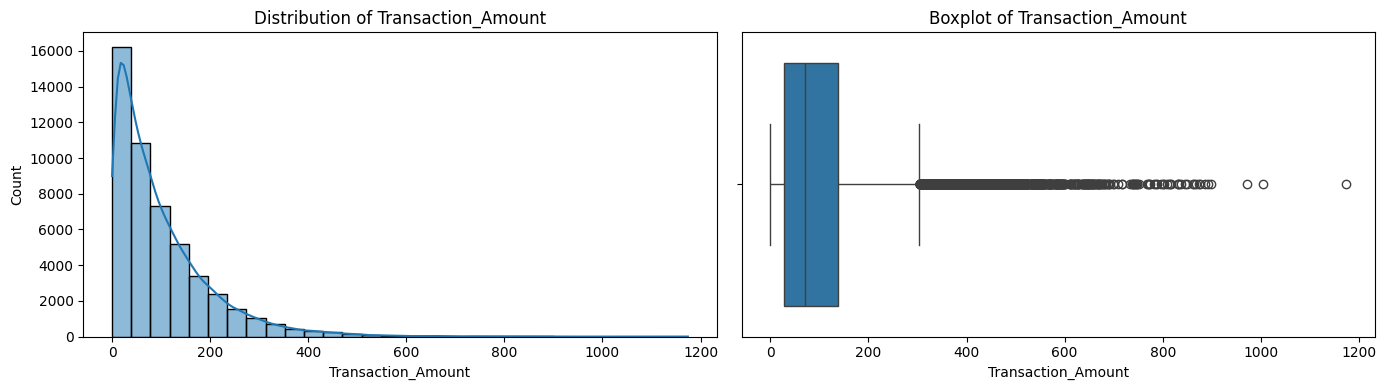

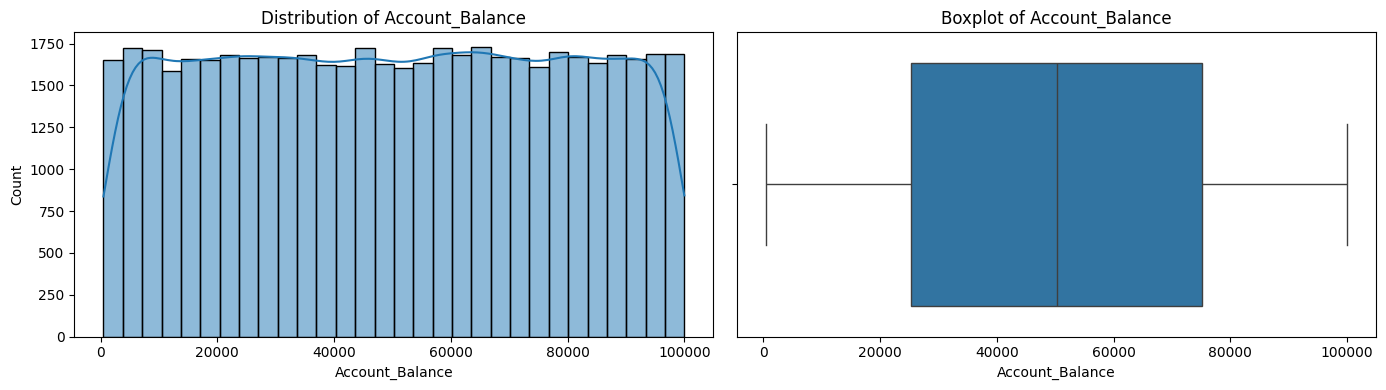

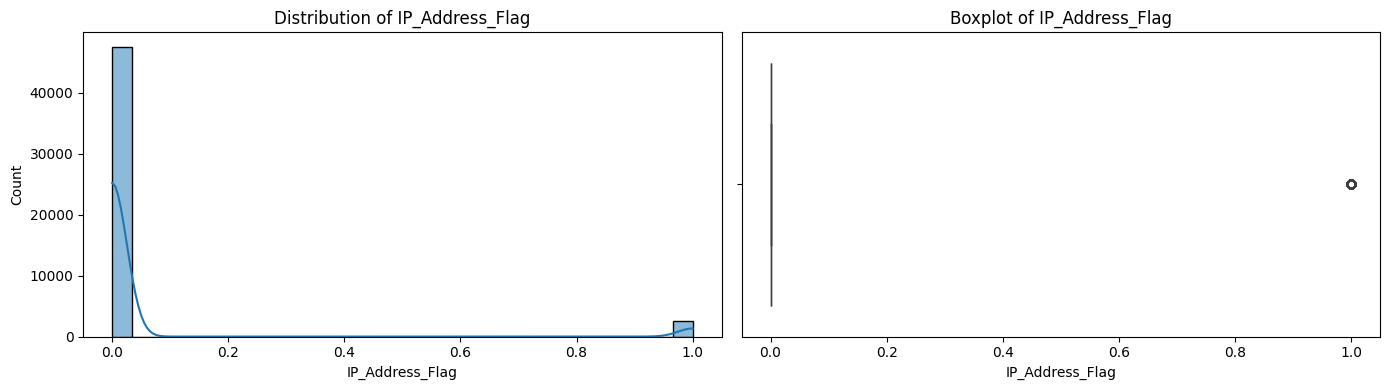

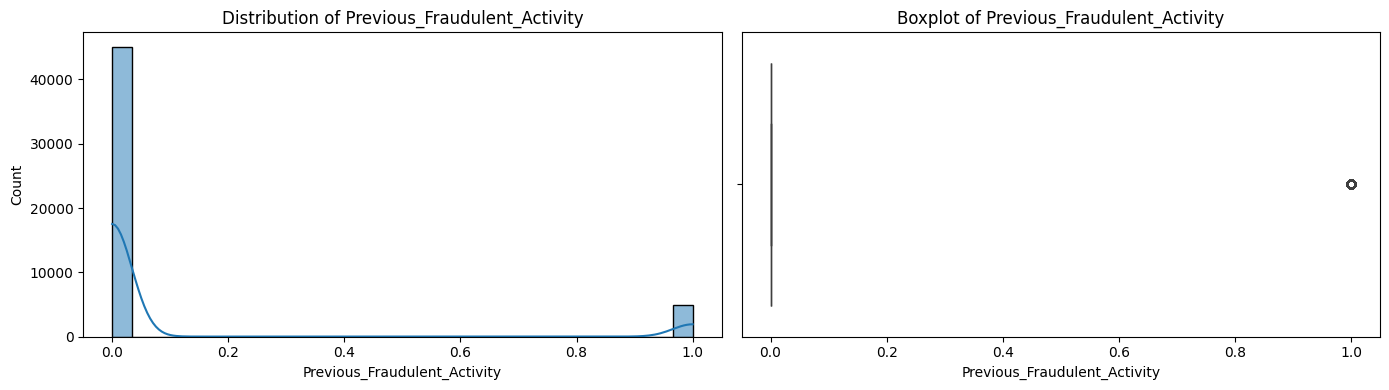

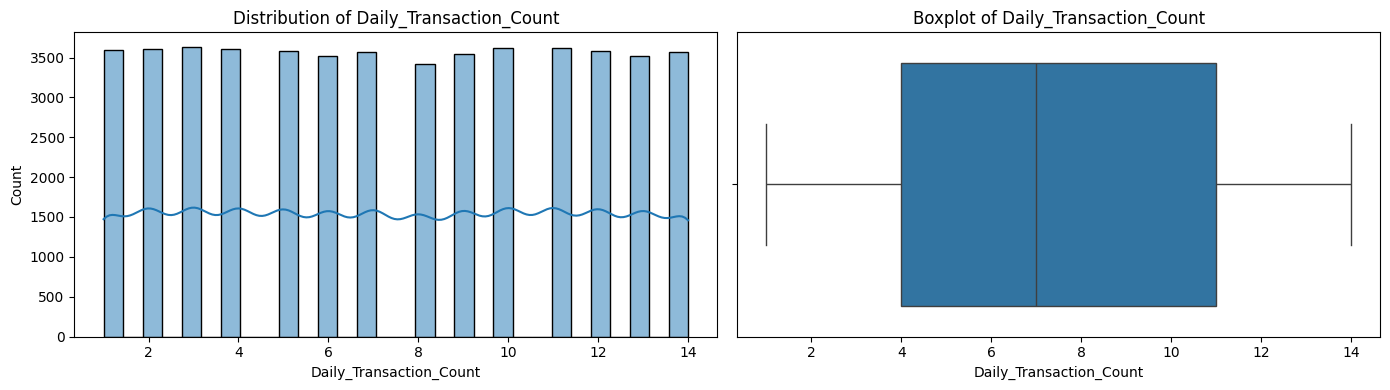

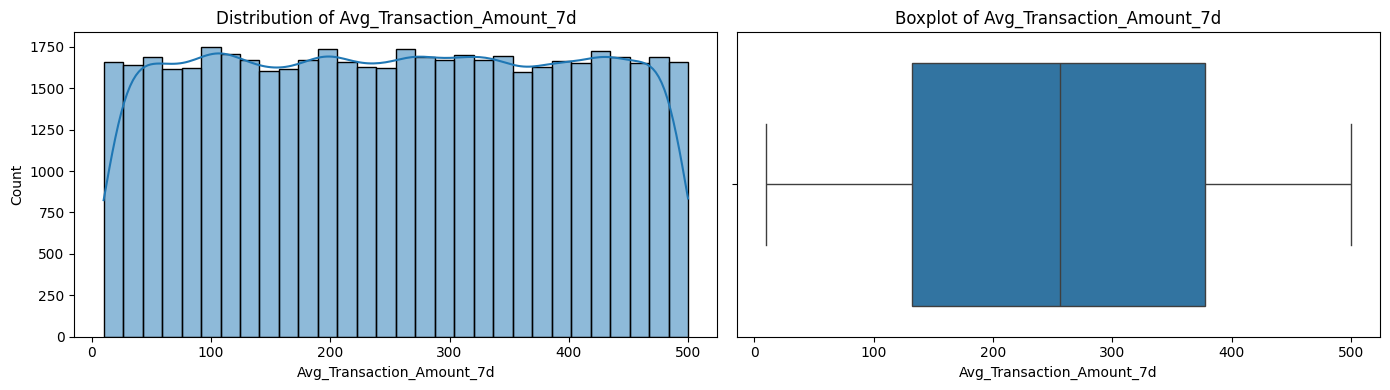

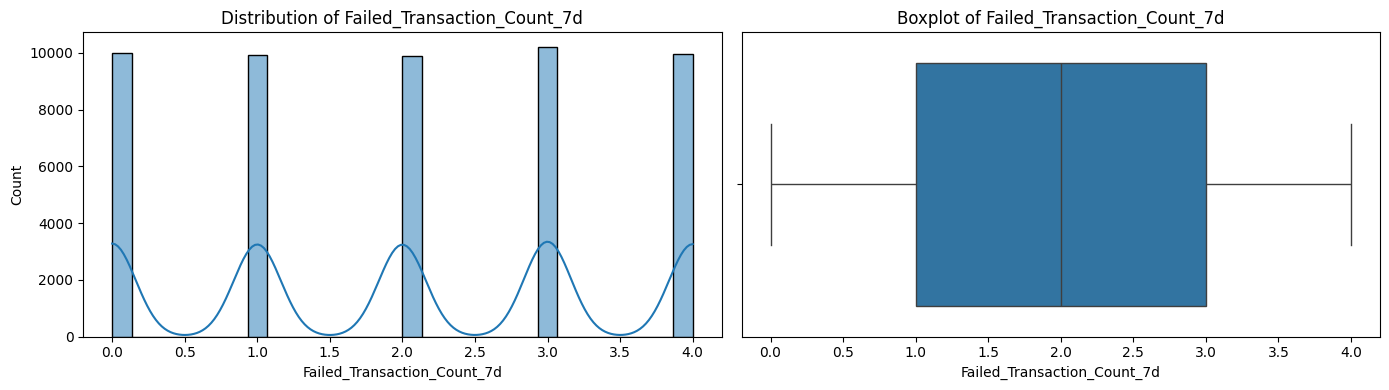

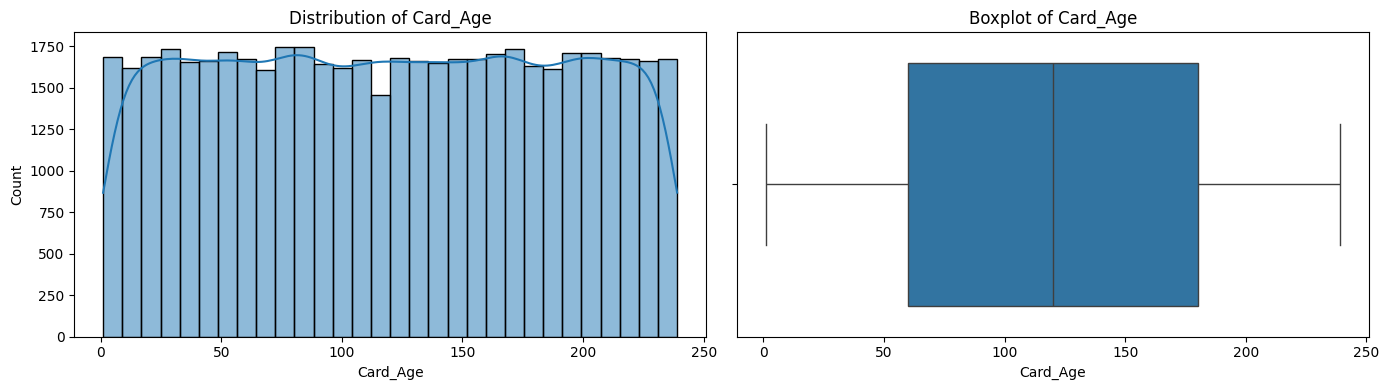

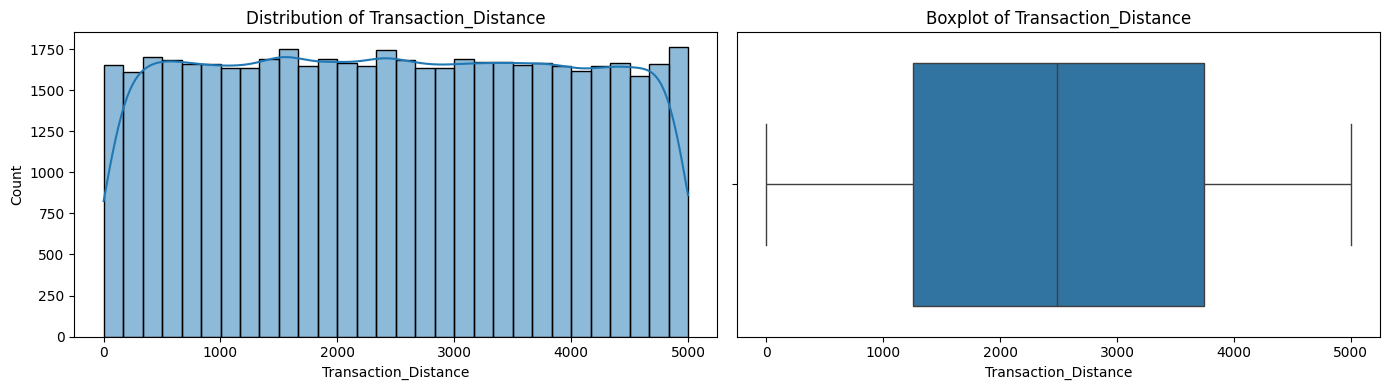

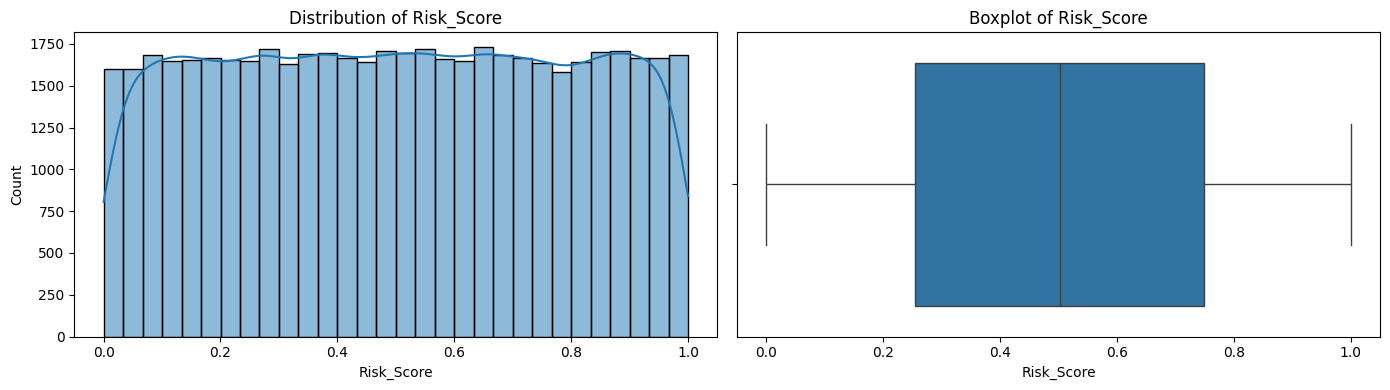

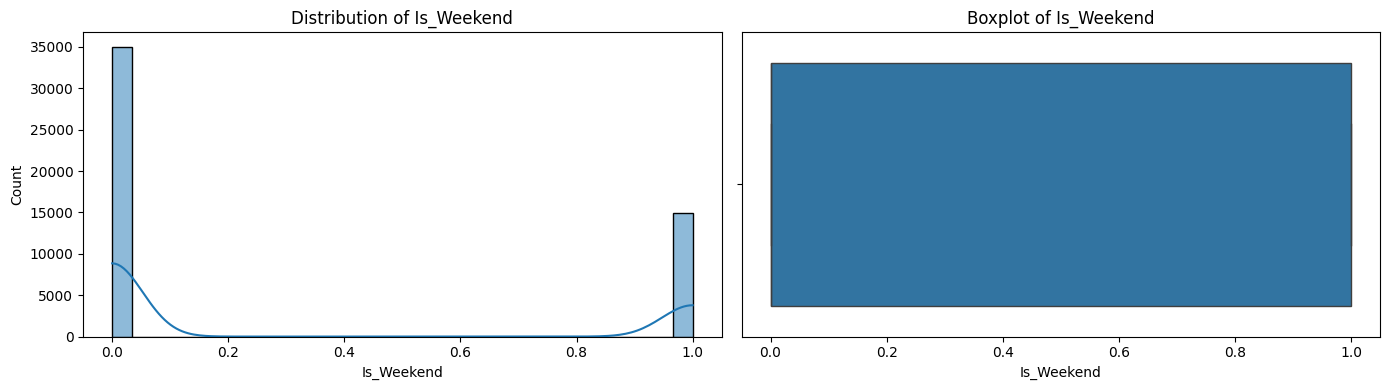

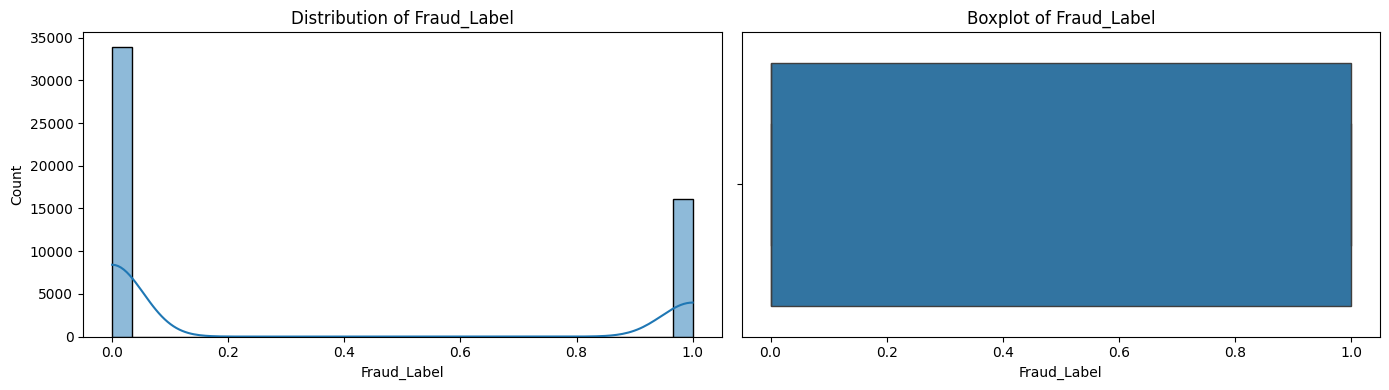

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(14, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


In [13]:
## appling the log transformation on the skewed features
data['Transaction_Amount_Log'] = np.log1p(data['Transaction_Amount'])


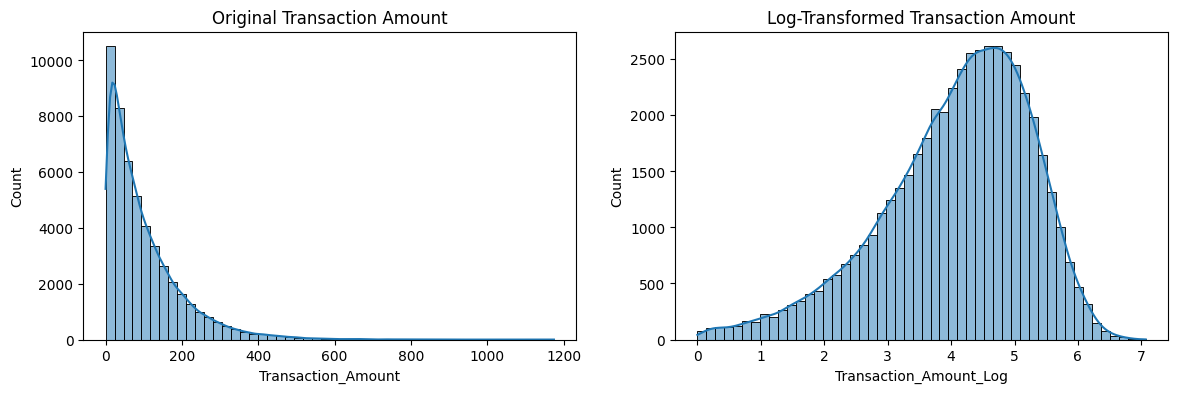

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(data['Transaction_Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Original Transaction Amount")

sns.histplot(data['Transaction_Amount_Log'], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Log-Transformed Transaction Amount")

plt.show()


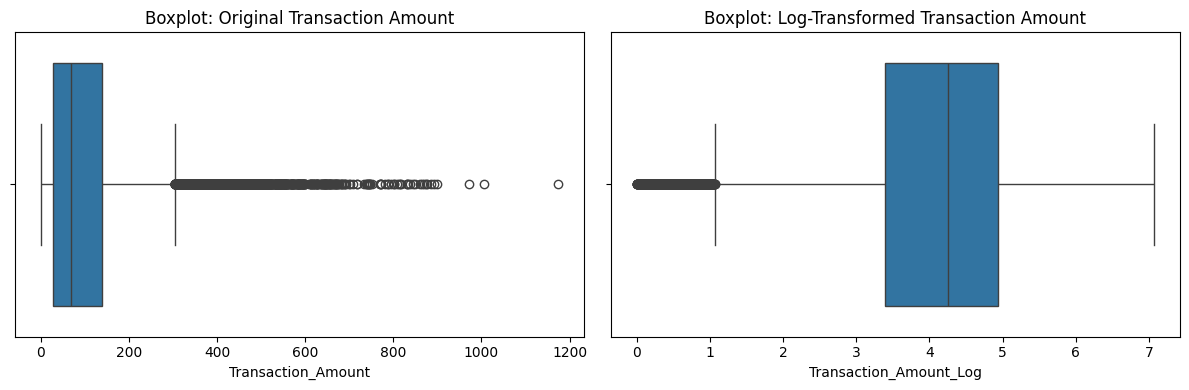

In [17]:
plt.figure(figsize=(12,4))

# Original Amount Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=data['Transaction_Amount'])
plt.title("Boxplot: Original Transaction Amount")

# Log Amount Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=data['Transaction_Amount_Log'])
plt.title("Boxplot: Log-Transformed Transaction Amount")

plt.tight_layout()
plt.show()


In [21]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

#### Univariate Analysis — Categorical Features

In [30]:
data['Location'].unique()


array(['Sydney', 'New York', 'Mumbai', 'Tokyo', 'London'], dtype=object)

In [31]:
data['Location'].nunique()


5

In [40]:
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    data[col].value_counts().plot(kind='bar')
    plt.title(f"Value Counts of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

    print(f"\nTop 10 values for {col}:\n", data[col].value_counts())
    print("-"*60)


KeyError: 'Transaction_ID'

<Figure size 1000x400 with 0 Axes>

### Transaction_ID column has no predictive value and will be removed before modeling.
##### Timestamp
Must be converted into derived features, such as:

Hour of the day

Day of week

Month

Weekend/weekday

Transaction time gap

In [32]:
# Drop the the personal identification columns
data.drop('Transaction_ID', axis=1, inplace=True)
data.drop('User_ID', axis=1, inplace=True)

In [33]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month
data.drop('Timestamp', axis=1, inplace=True)

In [34]:
data

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,...,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Transaction_Amount_Log,Hour,DayOfWeek,Month
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,...,65,883.17,Biometric,0.8494,0,0,3.708437,19,0,8
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,...,186,2203.36,Password,0.0959,0,1,0.783902,4,2,6
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,...,226,1909.29,Biometric,0.8400,0,1,3.399863,15,1,6
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,...,76,1311.86,OTP,0.7935,0,1,5.542518,0,3,12
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,...,140,966.98,Password,0.3819,1,1,3.474448,23,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,45.05,Online,76960.11,Mobile,Tokyo,Clothing,0,0,2,389.00,...,98,1537.54,PIN,0.1493,1,0,3.829728,18,6,1
49996,126.15,POS,28791.75,Mobile,Tokyo,Clothing,0,0,13,434.95,...,93,2555.72,Biometric,0.3653,0,1,4.845367,8,1,5
49997,72.02,Online,29916.41,Laptop,Mumbai,Clothing,0,1,1,369.15,...,114,4686.59,Biometric,0.5195,0,0,4.290733,19,0,1
49998,64.89,Bank Transfer,67895.67,Mobile,Tokyo,Electronics,0,0,13,242.29,...,72,4886.92,Biometric,0.7063,0,1,4.187987,19,3,3


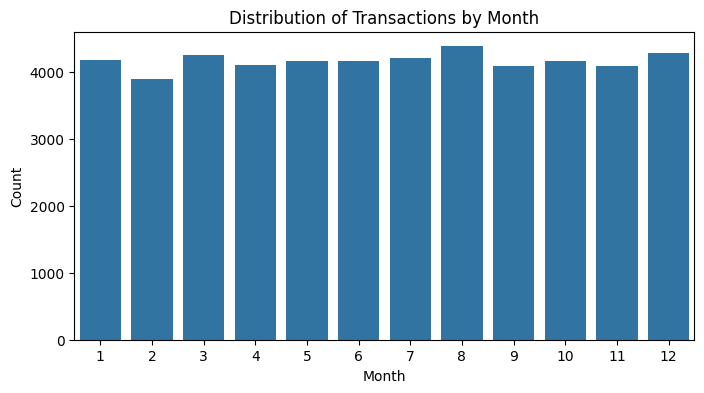

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Month'])
plt.title("Distribution of Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

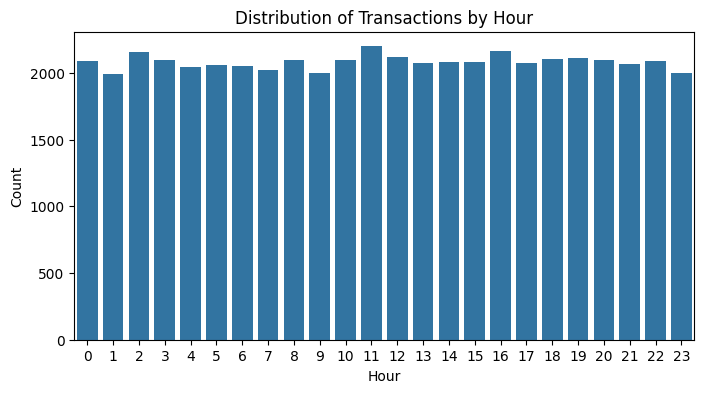

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Hour'])
plt.title("Distribution of Transactions by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

In [37]:
### as they are constant it will not add any value to the model so dropping them
data.drop(['Hour', 'Month',"DayOfWeek"], axis=1, inplace=True)

In [38]:
data.head()

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Transaction_Amount_Log
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0,3.708437
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1,0.783902
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1,3.399863
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1,5.542518
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1,3.474448


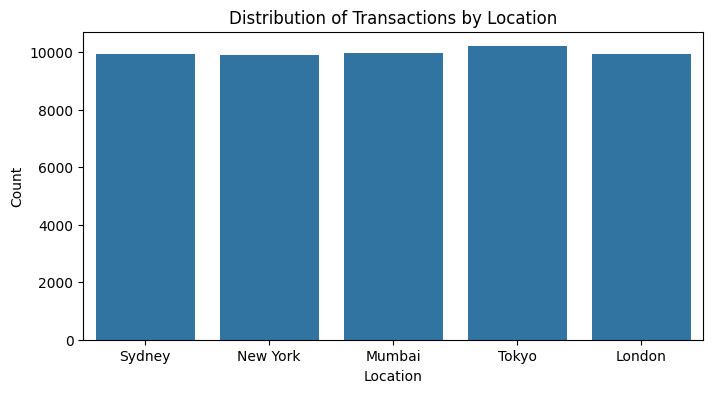

In [39]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Location'])
plt.title("Distribution of Transactions by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

In [41]:
## as the location is not necessary so i am droping the location column
data.drop('Location', axis=1, inplace=True)